# Evaluate DeepFace's Results In The Big Picture

In [3]:
import pandas as pd
from IPython.display import display, HTML
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
# all configuration alternatives for 4 dimensions of arguments
alignment = True
models = ["Facenet", "VGG-Face", "ArcFace", "GhostFaceNet", "OpenFace"]
detectors = ["retinaface", "centerface", "yunet", "yolov8"]
distance_metrics = ["euclidean", "euclidean_l2", "cosine"]

# Main results

In [7]:
for metric in distance_metrics:
    df = pd.read_csv(f"results/pivot_{metric}.csv")
    df = df.rename(columns = {'Unnamed: 0': 'detector'})
    df = df.set_index('detector')

    print(f"{metric}")
    display(HTML(df.to_html()))
    display(HTML("<hr>"))

euclidean


,Facenet,VGG-Face,ArcFace,GhostFaceNet,OpenFace
detector,,,,,
retinaface,85.9,93.5,82.3,81.4,70.9
centerface,90.1,94.2,80.1,83.1,68.1
yunet,89.6,94.1,79.3,82.4,69.1
yolov8,86.1,94.2,80.9,82.4,68.1


euclidean_l2


,Facenet,VGG-Face,ArcFace,GhostFaceNet,OpenFace
detector,,,,,
retinaface,92.3,93.5,93.3,88.9,70.9
centerface,91.8,94.2,93.6,87.7,68.1
yunet,89.5,94.1,91.5,87.1,69.1
yolov8,92.2,94.2,93.5,90.6,68.1


cosine


,Facenet,VGG-Face,ArcFace,GhostFaceNet,OpenFace
detector,,,,,
retinaface,92.3,93.5,93.3,88.9,70.9
centerface,91.8,94.2,93.6,87.7,67.8
yunet,89.5,94.1,91.5,87.1,69.1
yolov8,92.2,94.2,93.5,90.6,68.1


In [8]:
def create_github_table():
    for metric in distance_metrics:

        df = pd.read_csv(f"results/pivot_{metric}.csv")
        df = df.rename(columns = {'Unnamed: 0': 'detector'})
        df = df.set_index('detector')

        print(f"Performance Matrix for {metric}\n")
        header = "| | "
        for col_name in df.columns.tolist():
            header += f"{col_name} |"
        print(header)
        # -------------------------------
        seperator = "| --- | "
        for col_name in df.columns.tolist():
            seperator += " --- |"
        print(seperator)
        # -------------------------------
        for index, instance in df.iterrows():
            line = f"| {instance.name} |"
            for i in instance.values:
                if i < 97.5:
                    line += f"{i} |"
                else:
                    line += f"**{i}** |"
            print(line)

        print("\n---------------------------")

In [9]:
create_github_table()

Performance Matrix for euclidean

| | Facenet |VGG-Face |ArcFace |GhostFaceNet |OpenFace |
| --- |  --- | --- | --- | --- | --- |
| retinaface |85.9 |93.5 |82.3 |81.4 |70.9 |
| centerface |90.1 |94.2 |80.1 |83.1 |68.1 |
| yunet |89.6 |94.1 |79.3 |82.4 |69.1 |
| yolov8 |86.1 |94.2 |80.9 |82.4 |68.1 |

---------------------------
Performance Matrix for euclidean_l2

| | Facenet |VGG-Face |ArcFace |GhostFaceNet |OpenFace |
| --- |  --- | --- | --- | --- | --- |
| retinaface |92.3 |93.5 |93.3 |88.9 |70.9 |
| centerface |91.8 |94.2 |93.6 |87.7 |68.1 |
| yunet |89.5 |94.1 |91.5 |87.1 |69.1 |
| yolov8 |92.2 |94.2 |93.5 |90.6 |68.1 |

---------------------------
Performance Matrix for cosine

| | Facenet |VGG-Face |ArcFace |GhostFaceNet |OpenFace |
| --- |  --- | --- | --- | --- | --- |
| retinaface |92.3 |93.5 |93.3 |88.9 |70.9 |
| centerface |91.8 |94.2 |93.6 |87.7 |67.8 |
| yunet |89.5 |94.1 |91.5 |87.1 |69.1 |
| yolov8 |92.2 |94.2 |93.5 |90.6 |68.1 |

---------------------------


# facial recognition model's best scores

In [16]:
df = pd.DataFrame()

for distance_metric in distance_metrics:
    tmp_df = (
        pd.read_csv(f"results/pivot_{distance_metric}.csv")
        .rename(columns = {'Unnamed: 0': 'detector'})
        .set_index('detector')
    )
    df = pd.concat([df, tmp_df])

pivot_df = pd.DataFrame(df.max(), columns = ["best_accuracy_score"])

# add human comparison
pivot_df.loc["Human-beings"] = 97.5

pivot_df = pivot_df.sort_values(by = ["best_accuracy_score"], ascending = False)
pivot_df

,best_accuracy_score
Human-beings,97.5
VGG-Face,94.2
ArcFace,93.6
Facenet,92.3
GhostFaceNet,90.6
OpenFace,70.9


# ROC Curves

In [20]:
def plot_roc(model_name, detector_backend, distance_metric, align):
    alignment_text = "aligned"

    df = pd.read_csv(f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{alignment_text}.csv")
    
    #normalize
    df["distances_normalized"] = df["distances"] / df["distances"].max()
    df["actuals_normalized"] = 0
    idx = df[df["actuals"] == False].index
    df.loc[idx, "actuals_normalized"] = 1
    
    y_actual = df["actuals_normalized"].values.tolist()
    y_pred_proba = df["distances_normalized"].values.tolist()
    
    fpr, tpr, _ = metrics.roc_curve(y_actual, y_pred_proba)
    auc = metrics.roc_auc_score(y_actual, y_pred_proba)
    auc = round(auc, 4)

    # best accuracy score
    result_path = f"results/pivot_{distance_metric}.csv"
    result_df = pd.read_csv(result_path)
    acc = result_df[result_df["Unnamed: 0"] == detector_backend][model_name].values[0]

    label = f"{model_name}_{detector_backend}_{distance_metric}_{alignment_text} (acc: {acc}, auc: {auc})"

    return acc, auc, fpr, tpr, label

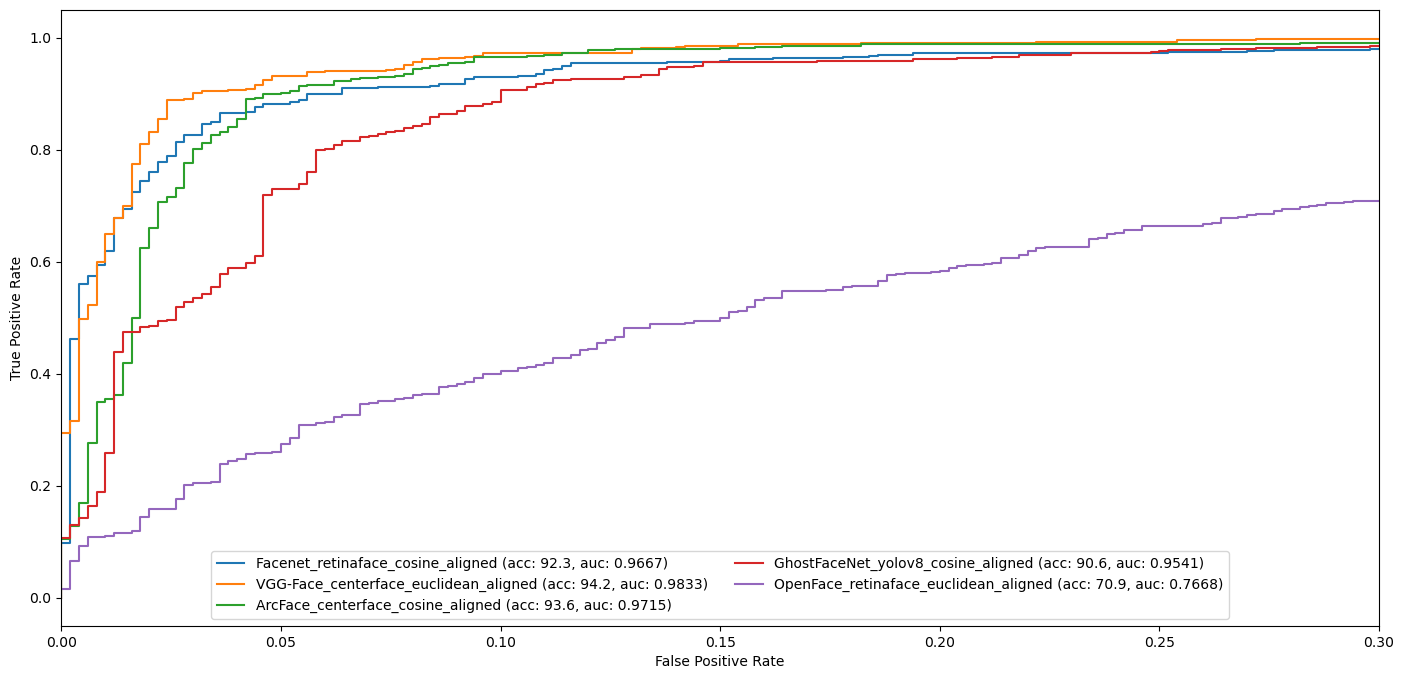

In [21]:
# to show all models in same graph
plt.figure(figsize=(17, 8))

for model_name in models:
    # to show graphs model by model
    # plt.figure(figsize=(17, 8))
    accs = []
    aucs = []
    fprs = []
    tprs = []
    labels = []
    for distance_metric in distance_metrics:
        # for detector_backend in robust_face_detectors:
        for detector_backend in detectors:
            acc, auc, fpr, tpr, label = plot_roc(model_name, detector_backend, distance_metric, True)
            accs.append(acc)
            aucs.append(auc)
            fprs.append(fpr)
            tprs.append(tpr)
            labels.append(label)
    # ---------------------------------
    #sort by auc
    df = pd.DataFrame({"acc": accs, "auc": aucs, "fpr": fprs, "tpr": tprs, "label": labels})
    # df = df.sort_values(by = ["auc"], ascending = False).reset_index()
    df = df.sort_values(by = ["acc"], ascending = False).reset_index()
    
    for index, instance in df.iterrows():
        fpr = instance["fpr"]
        tpr = instance["tpr"]
        auc = instance["auc"]
        acc = instance["acc"]
        label = instance["label"]
        
        plt.plot(fpr, tpr, label=label)
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc="lower center", ncol=2)
        # normally this should be [0, 1] but that scale makes graphs not legible
        # plt.xlim([0, 1])
        plt.xlim([0, 0.3])

        # to show the best auc value
        break
    
    # to show graphs model by model
    # plt.show()
    # print("----------------")

# to show all models in same graph
plt.show()

In [22]:
df

,index,acc,auc,fpr,tpr,label
0,0,70.9,0.7668,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.016, 0.016, 0.066, 0.066, 0.092...",OpenFace_retinaface_euclidean_aligned (acc: 70...
1,4,70.9,0.7668,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.016, 0.016, 0.066, 0.066, 0.092...",OpenFace_retinaface_euclidean_l2_aligned (acc:...
2,8,70.9,0.7668,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.016, 0.016, 0.066, 0.066, 0.092...","OpenFace_retinaface_cosine_aligned (acc: 70.9,..."
3,2,69.1,0.7459,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.012, 0.012, 0.014, 0.014, 0.016...","OpenFace_yunet_euclidean_aligned (acc: 69.1, a..."
4,10,69.1,0.7459,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.012, 0.012, 0.014, 0.014, 0.016...","OpenFace_yunet_cosine_aligned (acc: 69.1, auc:..."
5,6,69.1,0.7459,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.012, 0.012, 0.014, 0.014, 0.016...",OpenFace_yunet_euclidean_l2_aligned (acc: 69.1...
6,3,68.1,0.7422,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.004, 0.004, 0.026, 0.026, 0.038...","OpenFace_yolov8_euclidean_aligned (acc: 68.1, ..."
7,1,68.1,0.7391,"[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[0.0, 0.002, 0.012, 0.012, 0.04, 0.04, 0.054, ...",OpenFace_centerface_euclidean_aligned (acc: 68...
8,7,68.1,0.7422,"[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[0.0, 0.002, 0.004, 0.004, 0.026, 0.026, 0.038...",OpenFace_yolov8_euclidean_l2_aligned (acc: 68....
9,5,68.1,0.7391,"[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[0.0, 0.002, 0.012, 0.012, 0.04, 0.04, 0.054, ...",OpenFace_centerface_euclidean_l2_aligned (acc:...
